In [2]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm

import torch
from torch.utils.data import DataLoader
from torchvision import transforms

from transformers import AdamW, get_scheduler

from jre_utils.datapath import (
    processed_pretraining_data_paths,
    pretraining_data_paths,
    pretrained_weights_paths,
)
from jre_utils.data import TimeSeriesDataset, PadAndMask, ToNumpy, ToTensor
from jre_utils.models import TimeSeriesTransformerModel
from jre_utils.engine import (
    evaluate,
    train,
    EarlyStopper,
)
from jre_utils.metrics import MSELossWeighted

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

In [3]:
dataset = "illness"
df = pd.read_csv(pretraining_data_paths[dataset])
date_time = pd.to_datetime(df.pop("date"), format='%Y/%m/%d %H:%M')

In [4]:
df

,% WEIGHTED ILI,%UNWEIGHTED ILI,AGE 0-4,AGE 5-24,ILITOTAL,NUM. OF PROVIDERS,OT
0,1.222620,1.166680,582,805,2060,754,176569
1,1.333440,1.216500,683,872,2267,785,186355
2,1.319290,1.130570,642,878,2176,831,192469
3,1.494840,1.252460,728,1045,2599,863,207512
4,1.471950,1.302370,823,1189,2907,909,223208
...,...,...,...,...,...,...,...
961,0.839059,0.846722,2756,3528,12913,3258,1525058
962,0.895958,0.908885,3203,3778,13979,3254,1538038
963,0.910926,0.941625,3478,3796,14389,3177,1528103
964,0.946945,0.972185,3734,3818,14999,3066,1542813


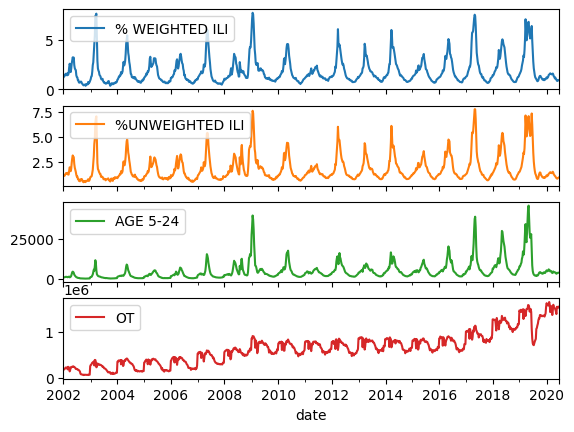

In [8]:
plot_cols = ['% WEIGHTED ILI', '%UNWEIGHTED ILI', 'AGE 5-24', 'OT']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)


In [9]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
% WEIGHTED ILI,966.0,1.851286,1.343042,0.351881,0.971185,1.375970,2.291583,7.715100e+00
%UNWEIGHTED ILI,966.0,1.845240,1.309019,0.491507,0.978537,1.359065,2.223535,7.780900e+00
AGE 0-4,966.0,3434.813665,3153.962885,98.000000,1487.000000,2552.000000,4457.750000,2.409700e+04
AGE 5-24,966.0,4981.128364,5953.881662,91.000000,1667.500000,3265.500000,5673.500000,4.551300e+04
ILITOTAL,966.0,13540.716356,15010.894094,318.000000,4915.000000,9028.500000,16243.750000,1.113610e+05
NUM. OF PROVIDERS,966.0,1608.261905,681.580042,264.000000,1238.000000,1501.500000,1990.000000,3.453000e+03
OT,966.0,651497.459627,349018.888124,64699.000000,385369.750000,618305.000000,813469.500000,1.640587e+06


In [10]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.9)]
val_df = df[int(n*0.9):]

num_features = df.shape[1]

In [11]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std

In [12]:
train_df

,% WEIGHTED ILI,%UNWEIGHTED ILI,AGE 0-4,AGE 5-24,ILITOTAL,NUM. OF PROVIDERS,OT
0,-0.469639,-0.525555,-1.003700,-0.730227,-0.812204,-1.304720,-1.466121
1,-0.383720,-0.485085,-0.965156,-0.717237,-0.795101,-1.247917,-1.430358
2,-0.394691,-0.554888,-0.980803,-0.716073,-0.802620,-1.163628,-1.408015
3,-0.258586,-0.455873,-0.947983,-0.683695,-0.767669,-1.104993,-1.353040
4,-0.276333,-0.415330,-0.911729,-0.655776,-0.742221,-1.020704,-1.295678
...,...,...,...,...,...,...,...
864,-0.089268,-0.074445,0.948686,0.397388,0.720494,1.923908,2.262530
865,-0.202811,-0.195652,0.823132,0.317121,0.576231,1.867105,2.271779
866,-0.255927,-0.289574,0.601790,0.258763,0.431058,1.791978,2.178933
867,-0.254888,-0.252093,0.548363,0.185863,0.377517,1.594082,1.889714


In [13]:
train_df.to_csv(processed_pretraining_data_paths[dataset]["train"], index=False)
val_df.to_csv(processed_pretraining_data_paths[dataset]["eval"], index=False)

In [14]:
# df_std = (df - train_mean) / train_std
# df_std = df_std.melt(var_name='Column', value_name='Normalized')
# plt.figure(figsize=(12, 6))
# ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
# _ = ax.set_xticklabels(df.keys(), rotation=90)

In [15]:
BATCH_SIZE = 64
window_length = 10
shift = 1

feature_columns = df.columns
metrics = ["OT"]

train_dataset = TimeSeriesDataset(
    train_df,
    metrics=metrics,
    feature_columns=feature_columns,
    window_length=window_length,
    shift=shift,
    transform=transforms.Compose(
        [ToNumpy(), PadAndMask(pad_length=window_length), ToTensor()]
    ),
)
val_dataset = TimeSeriesDataset(
    val_df,
    metrics=metrics,
    feature_columns=feature_columns,
    window_length=window_length,
    shift=shift,
    transform=transforms.Compose(
        [ToNumpy(), PadAndMask(pad_length=window_length), ToTensor()]
    ),
)

In [16]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
eval_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [17]:
for i, sample in enumerate(train_dataloader):
    if i == 0:
        print(i, sample["window"].shape, sample["target"].shape)
        break

0 torch.Size([64, 10, 7]) torch.Size([64, 1])


In [18]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
# device = "cpu"
print(f"Using {device} device")

Using mps device


In [19]:
n_features = len(feature_columns)
target_size = len(metrics)
d_model = 128
d_hid = 256
nlayers = 4
nhead = 4
dropout = 0.1
enc_dropout = 0

model = TimeSeriesTransformerModel(
    n_features=n_features,
    target_size=target_size,
    d_model=d_model,
    nhead=nhead,
    d_hid=d_hid,
    nlayers=nlayers,
    dropout=dropout,
    device=device,
)
model = model.to(device)


In [20]:
n_features

7

In [34]:
model.eval()
mse_loss_weighted = MSELossWeighted().to(device)

with torch.no_grad():
    for batch in eval_dataloader:
        window = batch["window"].to(device)
        mask = batch["mask"].to(device)
        target = batch["target"].to(device)
        weight = batch["weight"].to(device)

        outputs = model(window, mask)
        loss = mse_loss_weighted(outputs, target, weight)

        print(
            batch["window"].shape,
            batch["mask"].shape,
            batch["target"].shape,
            batch["weight"].shape,
        )

        print(outputs.shape)
        print("Loss:", loss.item())

        if i == 0:
            break

torch.Size([64, 10, 7]) torch.Size([64, 10]) torch.Size([64, 1]) torch.Size([64, 1])
torch.Size([64, 1])
Loss: 0.17294225096702576


In [40]:
learning_rate = 1e-4
num_epochs = 20

In [41]:
train_losses, train_r2_scores = [], []
eval_losses, eval_r2_scores = [], []

In [42]:
num_training_steps = num_epochs * len(train_dataloader)

optimizer = AdamW(model.parameters(), lr=learning_rate)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

progress_bar = tqdm(range(num_training_steps))
early_stopper = EarlyStopper(patience=5, min_delta=0.01)

for epoch in range(num_epochs):
    train_loss, train_r2_score = train(
        model, train_dataloader, optimizer, lr_scheduler, progress_bar, device=device
    )
    train_losses.append(train_loss)
    train_r2_scores.append(train_r2_score)

    eval_loss, eval_r2_score = evaluate(model, eval_dataloader, device=device)
    eval_losses.append(eval_loss)
    eval_r2_scores.append(eval_r2_score)

    if early_stopper.early_stop(eval_loss):
        print(f"Early stopping at epoch {epoch}")
        break


progress_bar.close()

100%|██████████| 4900/4900 [07:14<00:00, 11.28it/s]


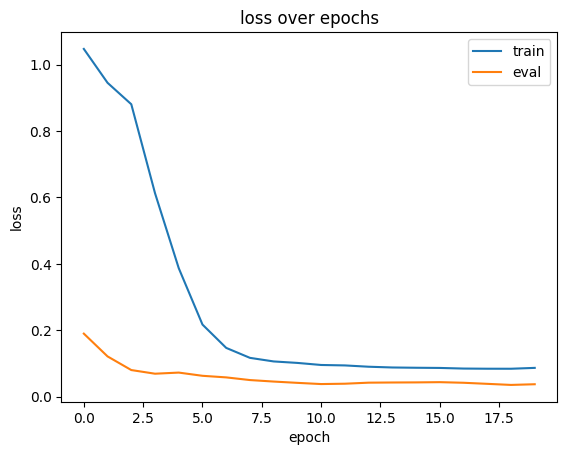

In [43]:
# Plot MSE
plt.plot(train_losses, label = "train")
plt.plot(eval_losses, label = "eval")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss over epochs')
plt.legend()
plt.show()

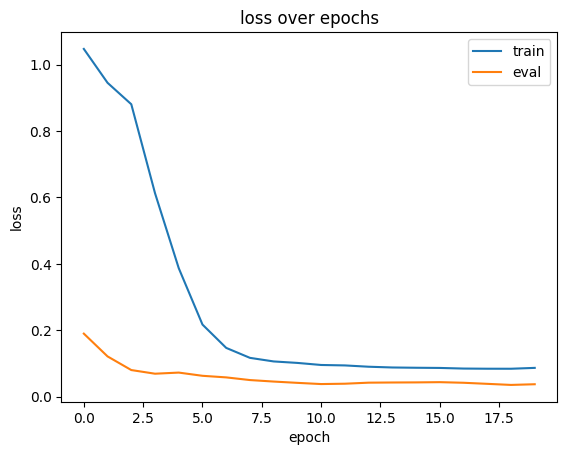

In [44]:
# Plot MSE
plt.plot(train_losses, label = "train")
plt.plot(eval_losses, label = "eval")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss over epochs')
plt.legend()
plt.show()

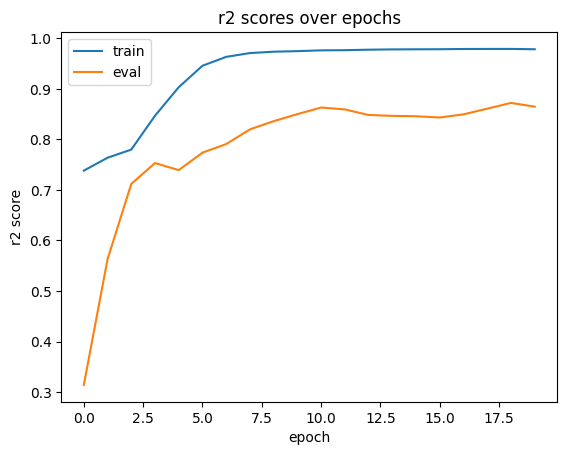

In [45]:
# Plot R2 scores
plt.plot(train_r2_scores, label = "train")
plt.plot(eval_r2_scores, label = "eval")
plt.xlabel('epoch')
plt.ylabel('r2 score')
plt.title('r2 scores over epochs')
plt.legend()
plt.show()